In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","

In [5]:
import plotnine

from plotnine import (
    ggplot,
    aes,
    after_stat,
    geom_histogram,
    facet_wrap,
    facet_grid,
    coord_flip,
    scale_y_continuous,
    scale_y_sqrt,
    scale_y_log10,
    scale_fill_manual,
    theme_bw,
    theme_xkcd

)

In [6]:
def getVal(mypath, filename, header="infer",names = None):
    fullpath = pathresults +mypath+filename
    if names is None:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header).dropna(how= "all", axis=1)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names).dropna(how= "all", axis=1)
    return cst
def get_last_line_as_numpy_array(file_path, dtype = float):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        last_line = lines[-1].strip()

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)

        return array_from_last_line

In [68]:
# cylinder max konz (per cell)
def getData_(name, cid,gId,path2file):
    fileName = "Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    if cid <= 2 and cid > 0:
        fileName = "Cyl_watercontent_"+str(gId)+".txt"
        theta = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
        cVol *= theta
    fileName = name+str(gId)+".txt"
    Q1 = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
    return konz

def getData():
    
    nToGet = 9+3 #elements + 3d coordinates of y node
    nKonz = 9
    dictXYZ = {9:'X',10:'Y',11:'Z'}
    GiniAll = [[[] for i in range(99)] for ii in range(nToGet)]
    for pSet in range(99):

        path2file = 'none_55_'+str(pSet)+'_10to11_20mn_0s_5/'
        #nodes_X =get_last_line_as_numpy_array(path2file+"nodes_X.txt", dtype =float)
        #nodes_Y =get_last_line_as_numpy_array(path2file+"nodes_Y.txt", dtype =float)
        #nodes_Z =get_last_line_as_numpy_array(path2file+"nodes_Z.txt", dtype =float)
        #dictXYZ = {10:nodes_X,11:nodes_Y,12:nodes_Z}
        rr = get_last_line_as_numpy_array(path2file+"root_segments_tips.txt", dtype =int)

        for cid in range(nKonz):
            Ginits = np.full(len(rr),np.nan)
            for idx, gId in enumerate(rr):
                if cid == 0:
                    namedata = "Cyl_watercontent_"
                elif cid <= nKonz:
                    namedata = "Cyl_content"+str(cid)+"_"
                Ginits[idx] = getData_(namedata, cid, gId,path2file)                
            GiniAll[cid][pSet] = Ginits
        for cid in range(nKonz,nToGet):
            nodes_ =get_last_line_as_numpy_array(path2file+"nodes_"+dictXYZ[cid]+".txt", dtype =float)
            GiniAll[cid][pSet] = nodes_[rr+1]#seg idx to y-idx
    return GiniAll #cid pSet rr
    

In [69]:
GiniAll = getData()

In [82]:
# get param set
paramsets =  pd.read_csv('../output_random_rows.csv')
paramsets = paramsets.drop(paramsets.columns.tolist()[-1],axis=1)
outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
column_names = outputvalsname + paramsets.columns.tolist()
df = pd.DataFrame(columns=column_names)

for pset in range(99):
    N = GiniAll[0][pset].shape[0]
    rows_to_duplicate_df = pd.DataFrame(paramsets.iloc[pset]).T
    duplicated_rows_df = rows_to_duplicate_df.loc[np.repeat(rows_to_duplicate_df.index.values, N)]
    # Duplicate the specific rows N times
    #print('init dupl row shape',duplicated_rows_df.shape)
    for jj, outVn in enumerate(outputvalsname):
        duplicated_rows_df[outVn] = GiniAll[jj][pset]
        #print('adding',jj,outVn,duplicated_rows_df.shape,len(GiniAll[jj][pset]))

    # Concatenate the original DataFrame with the duplicated specific rows
    df = pd.concat([df, duplicated_rows_df], ignore_index=True)

In [84]:
df.shape

(6336, 39)

In [85]:
df['co'] = df['coa']+df['cod']
df['cc'] = df['cca']+df['ccd']

In [86]:
df.to_pickle("./cyl10to11.pkl") 

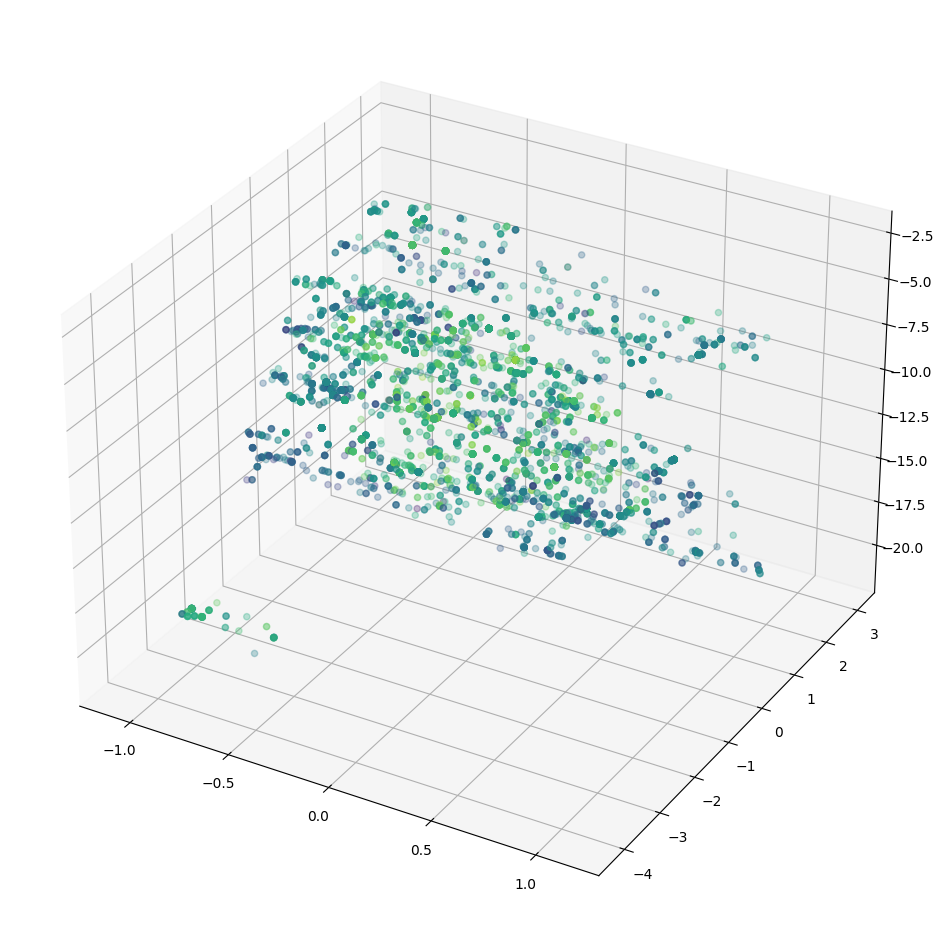

In [93]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['yX'], 
           df['yY'], 
           df['yZ'],
          c = np.log(df['cs']), alpha=0.3)
plt.show()

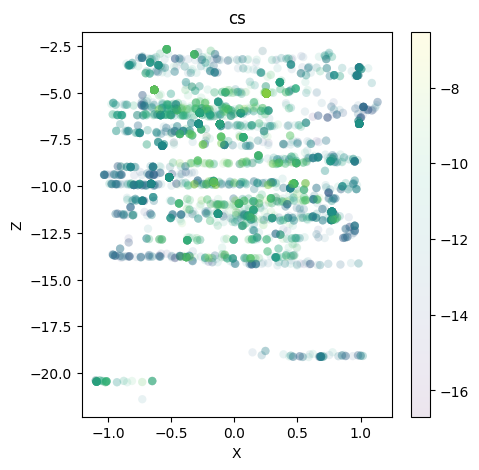

In [92]:


plt.scatter((df['yX']),(df['yZ']), #np.log(df['cc']),np.log(df['co']), 
            c=np.log(df['cs']),
            alpha=0.1, edgecolors ='none')
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
plt.title('cs')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

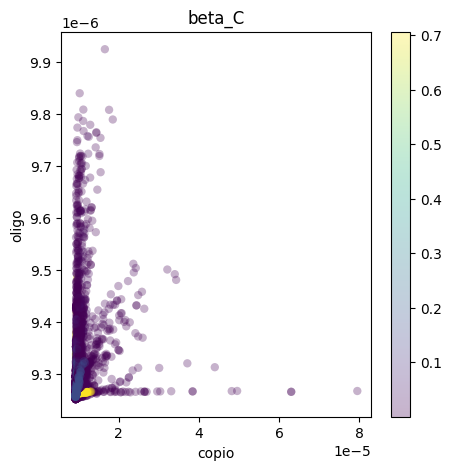

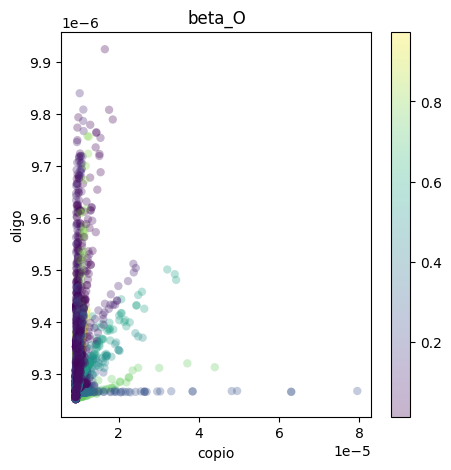

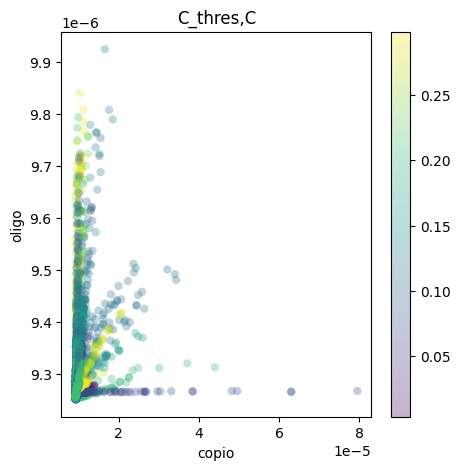

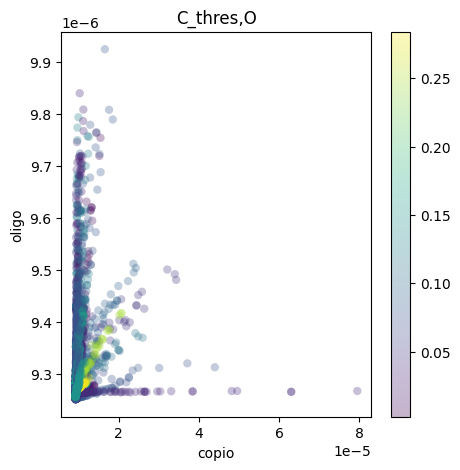

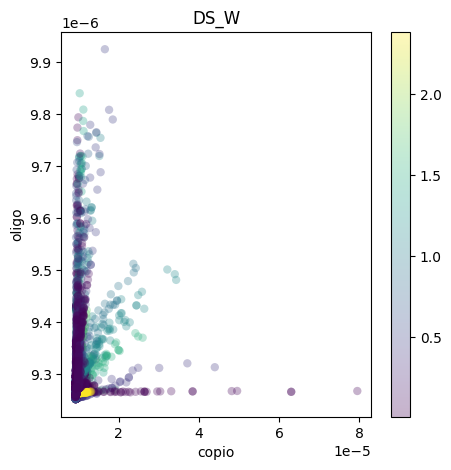

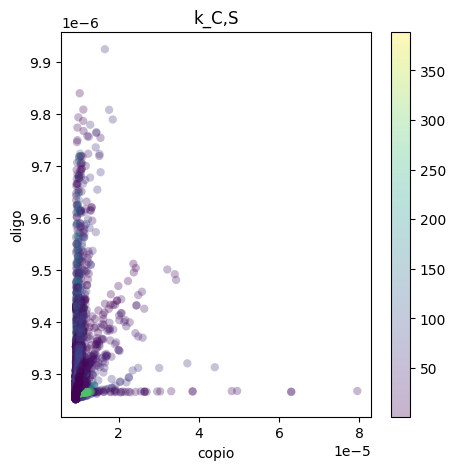

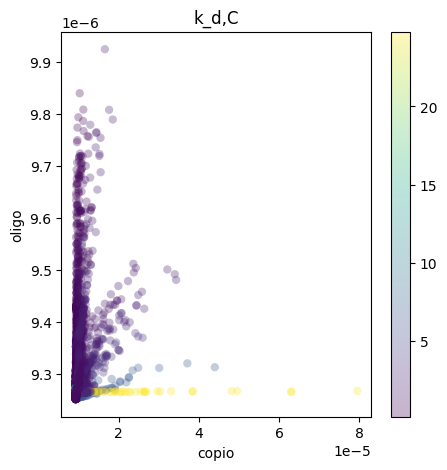

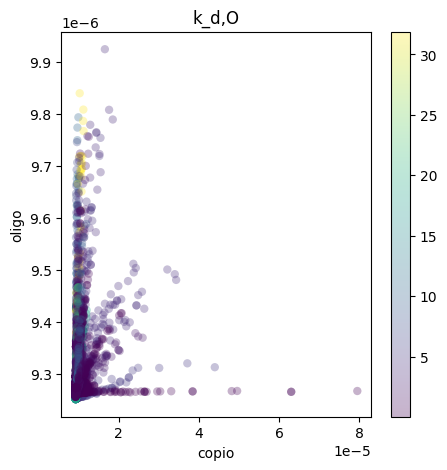

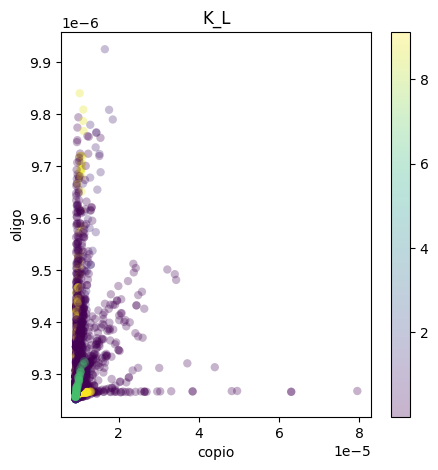

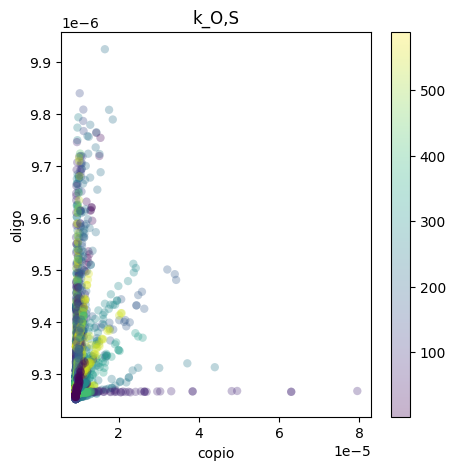

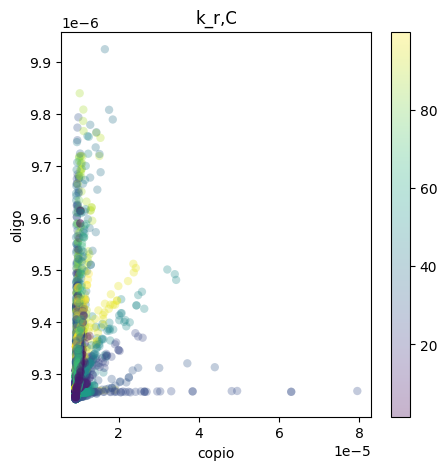

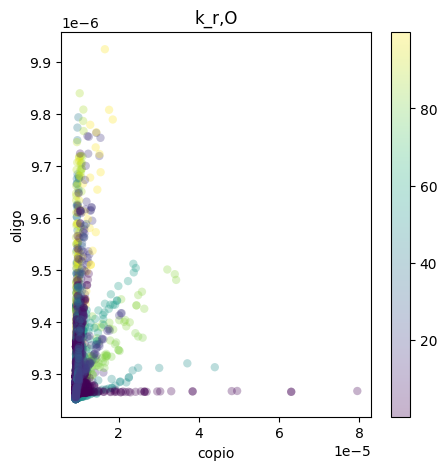

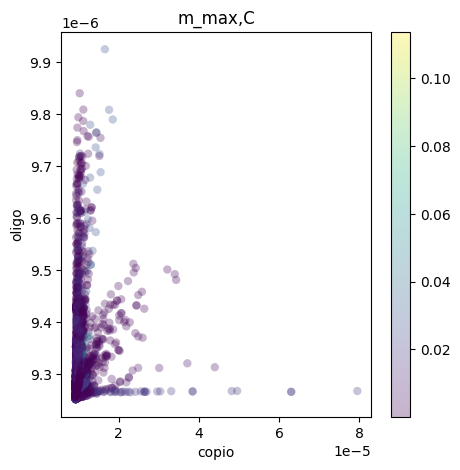

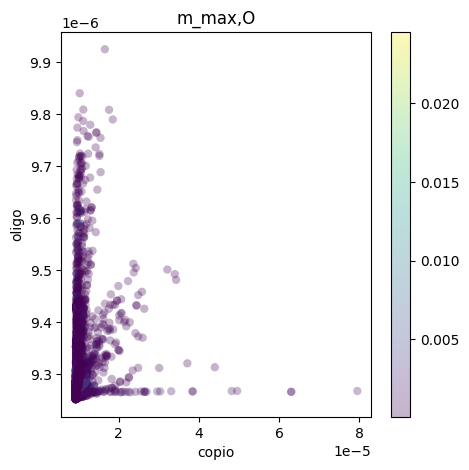

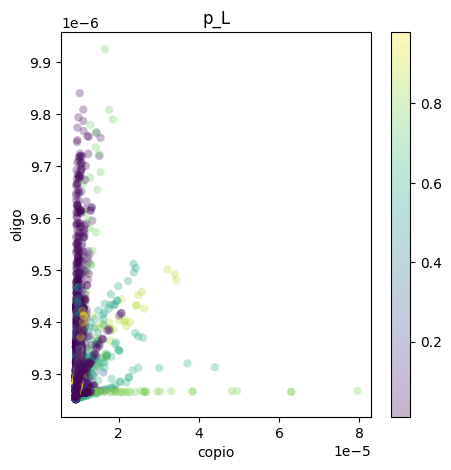

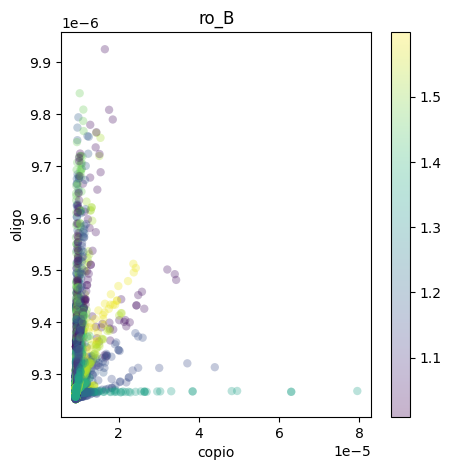

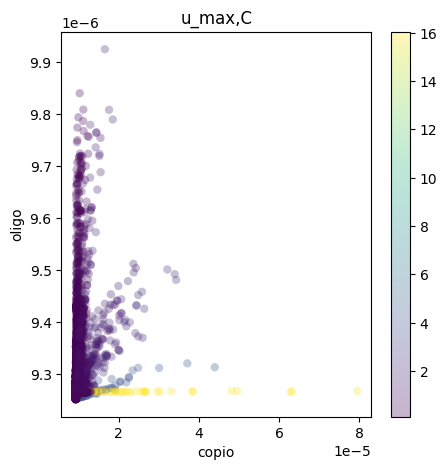

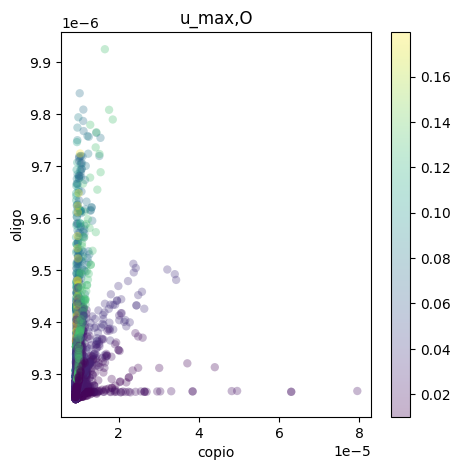

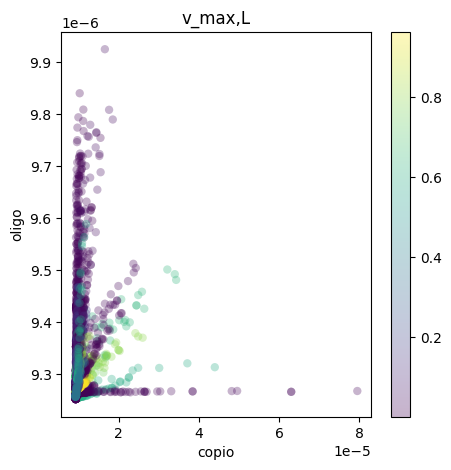

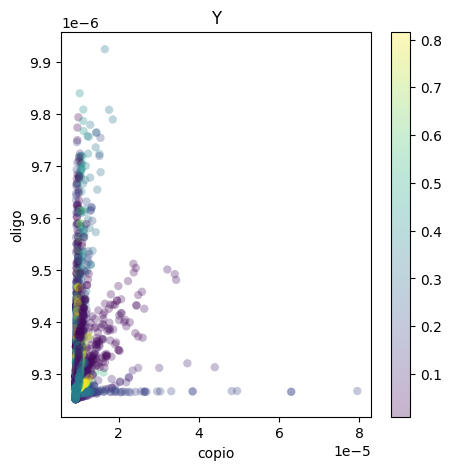

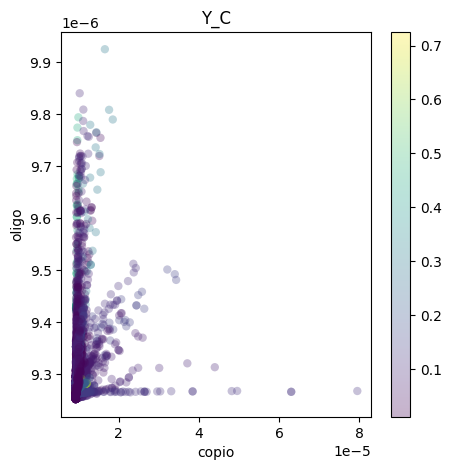

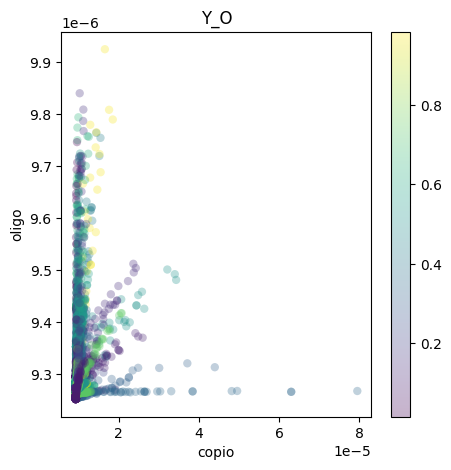

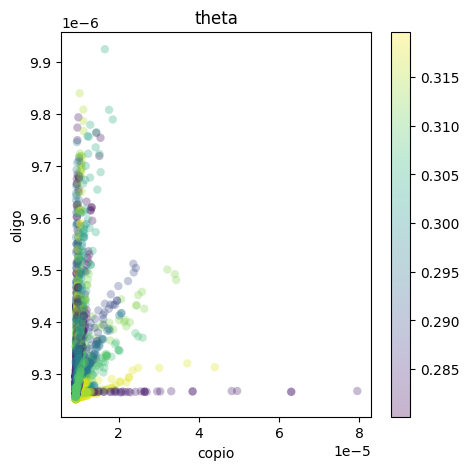

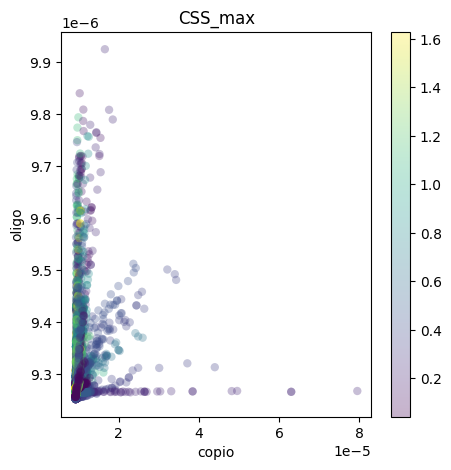

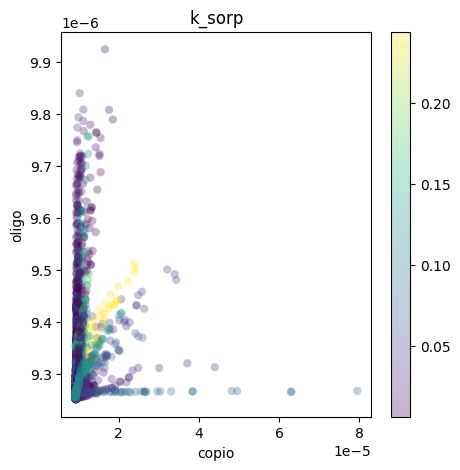

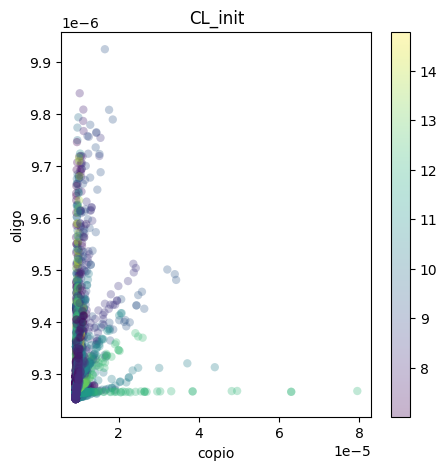

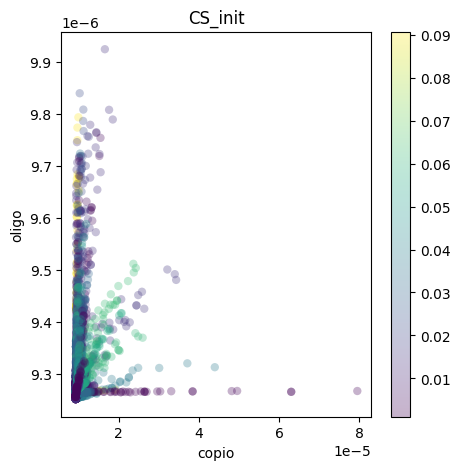

In [63]:
for nn in paramsets.columns.tolist():
    plt.scatter((df['cc']),(df['co']), #np.log(df['cc']),np.log(df['co']), 
                c=df[nn],
                alpha=0.3, edgecolors ='none')
    plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
    plt.title(nn)
    plt.colorbar()
    plt.xlabel('copio')
    plt.ylabel('oligo')
    plt.show()

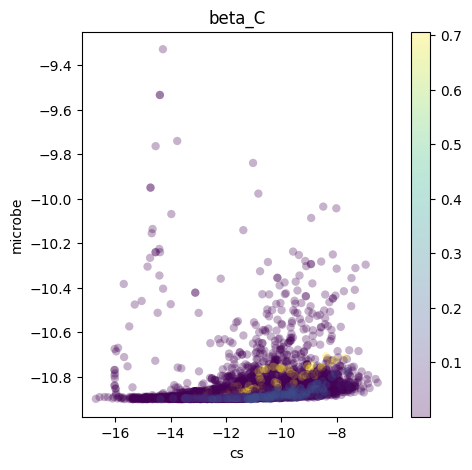

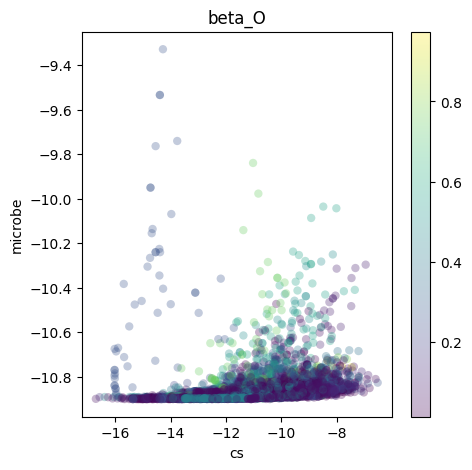

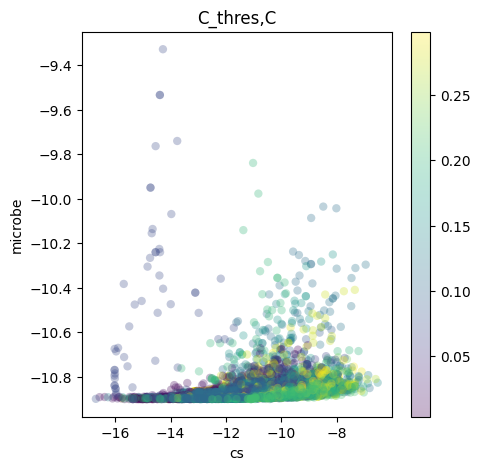

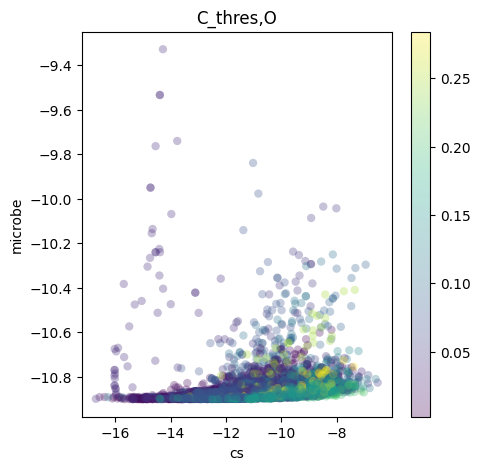

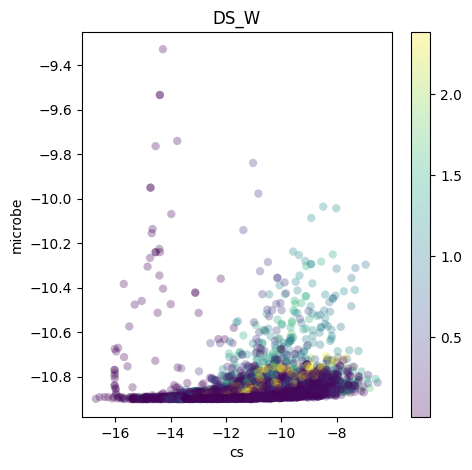

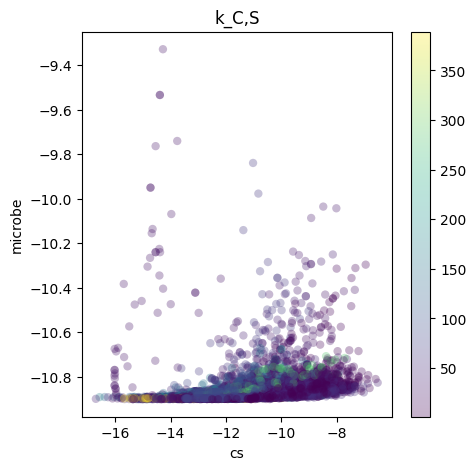

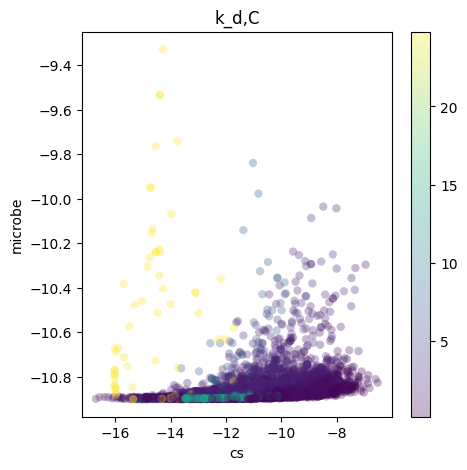

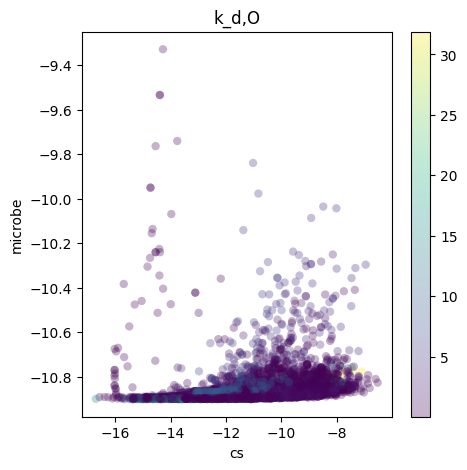

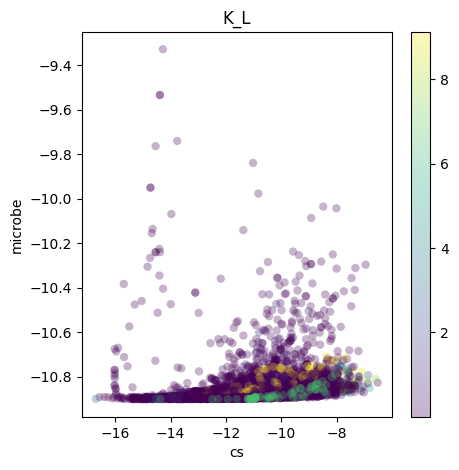

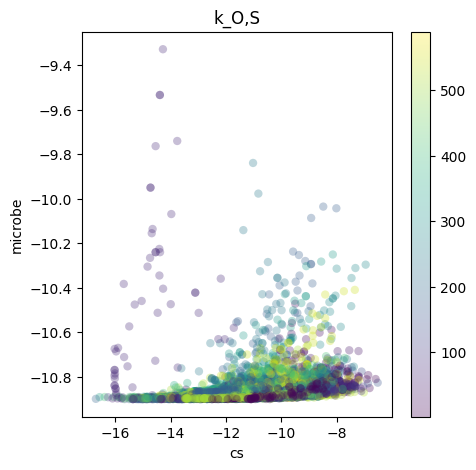

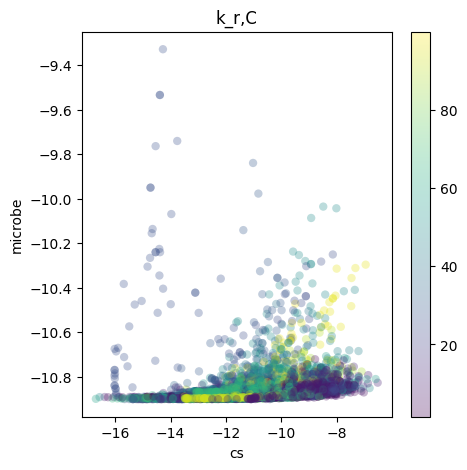

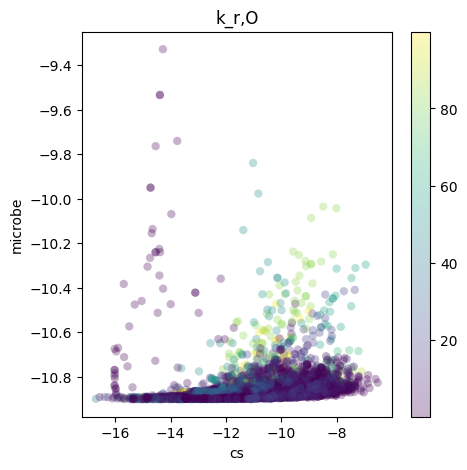

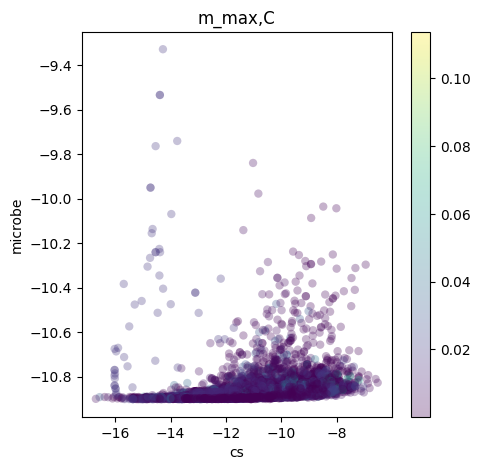

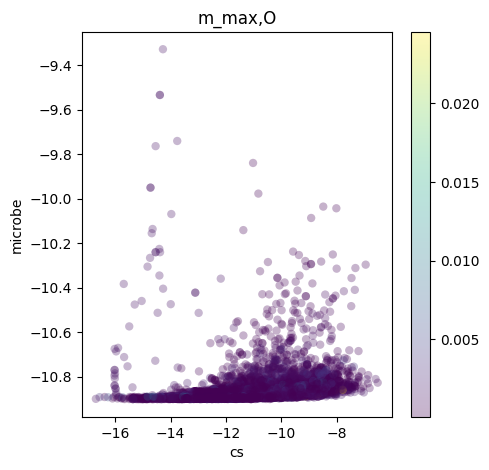

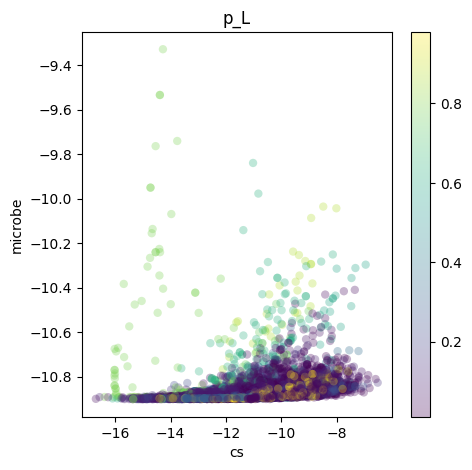

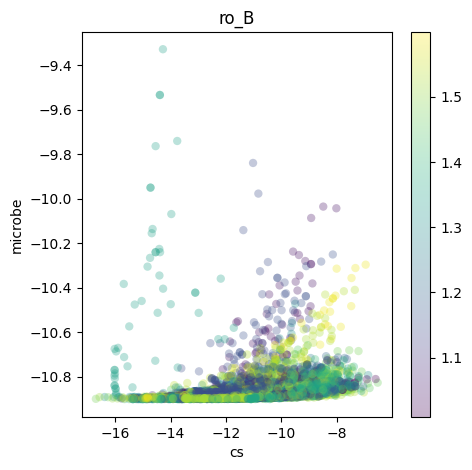

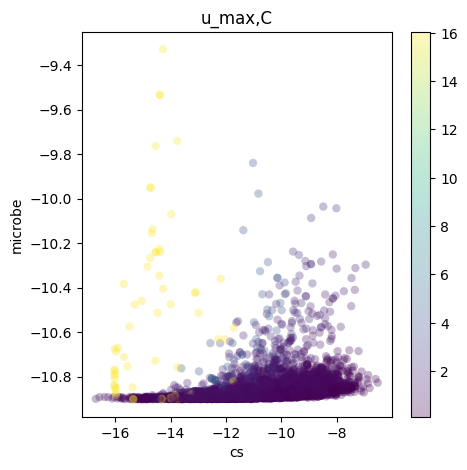

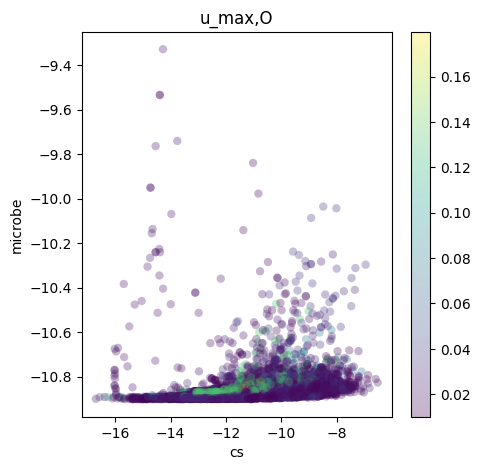

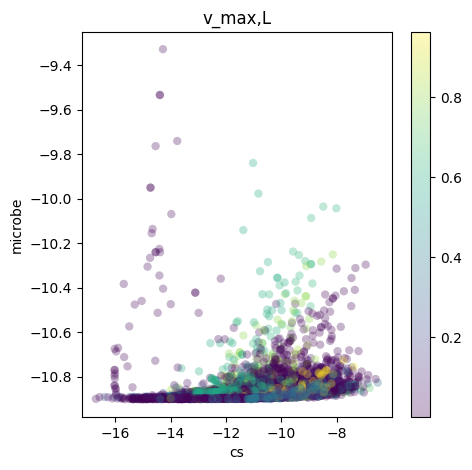

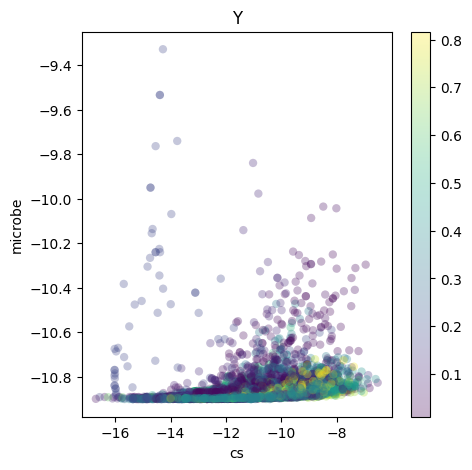

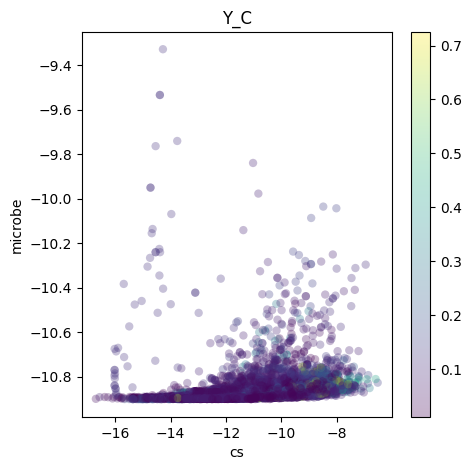

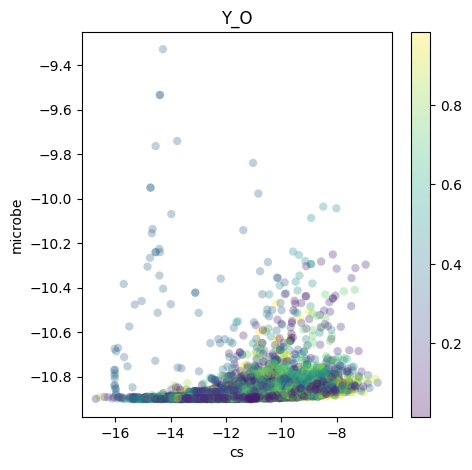

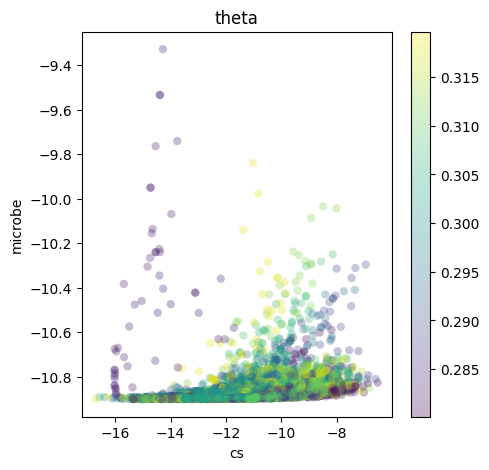

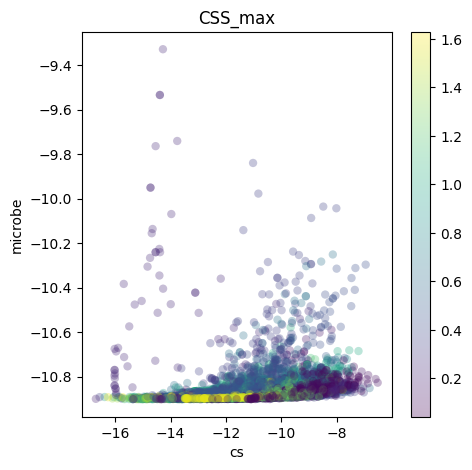

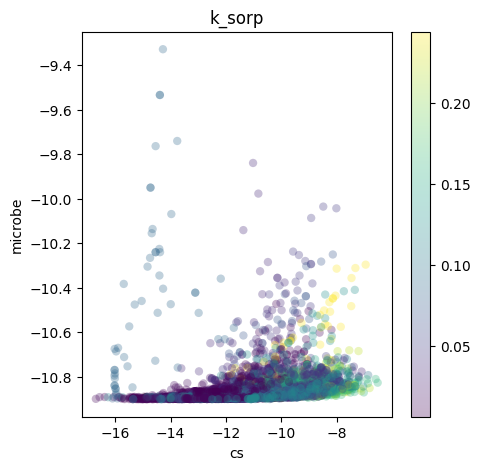

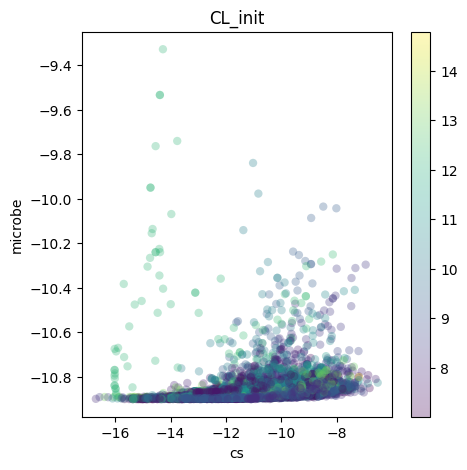

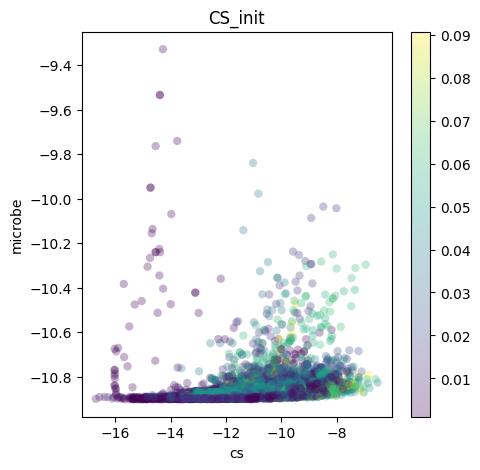

In [66]:
for nn in paramsets.columns.tolist():
    plt.scatter(np.log(df['cs']),np.log(df['co']+df['cc']), 
                c=df[nn],
                alpha=0.3, edgecolors ='none')
    plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
    plt.title(nn)
    plt.colorbar()
    plt.xlabel('cs')
    plt.ylabel('microbe')
    plt.show()

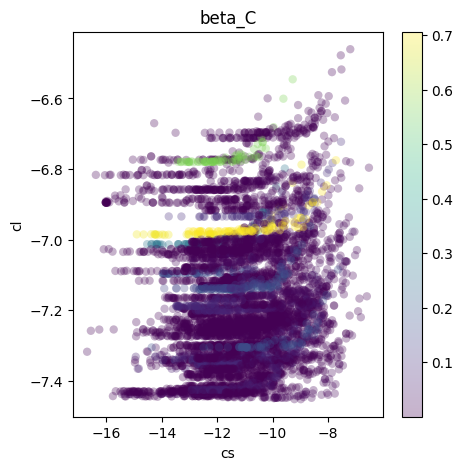

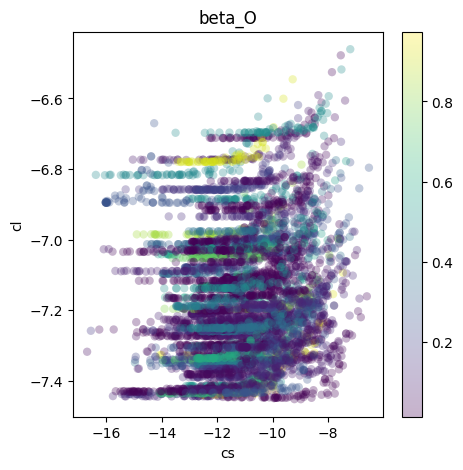

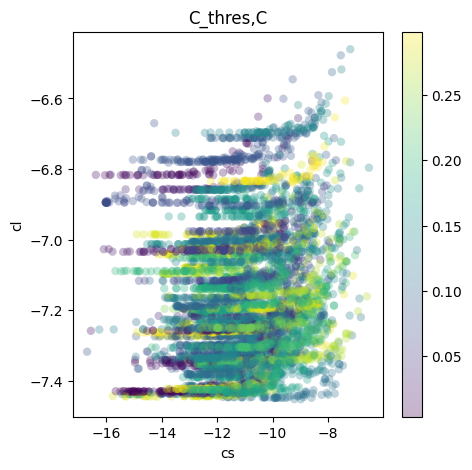

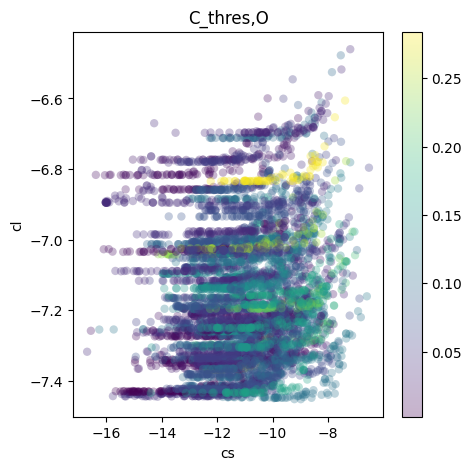

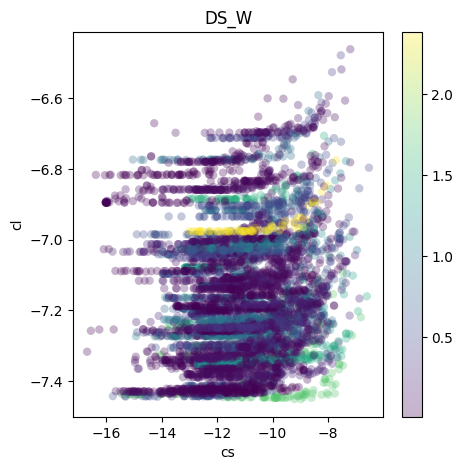

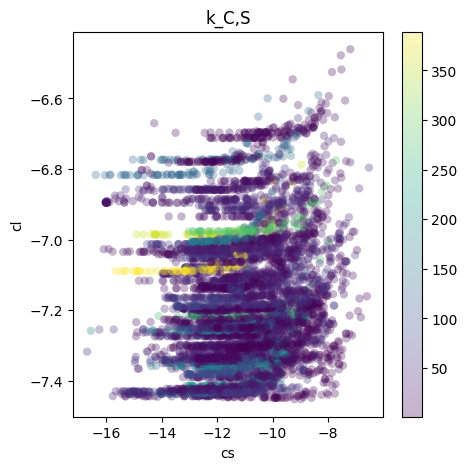

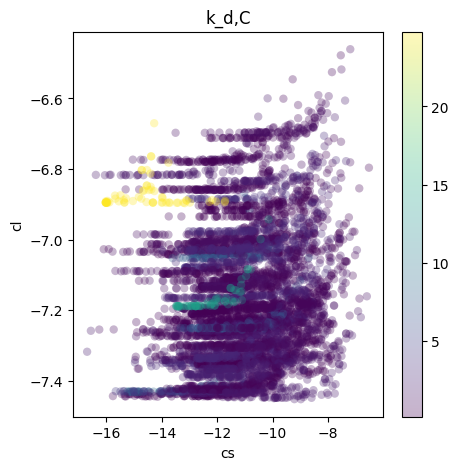

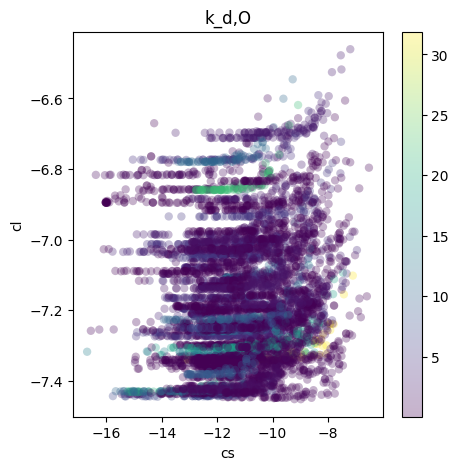

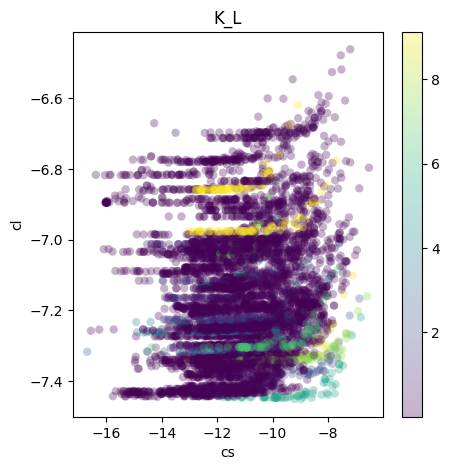

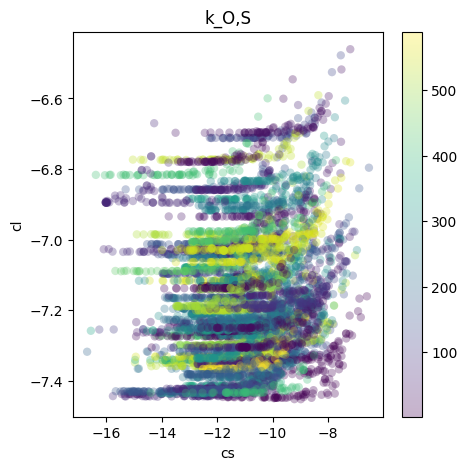

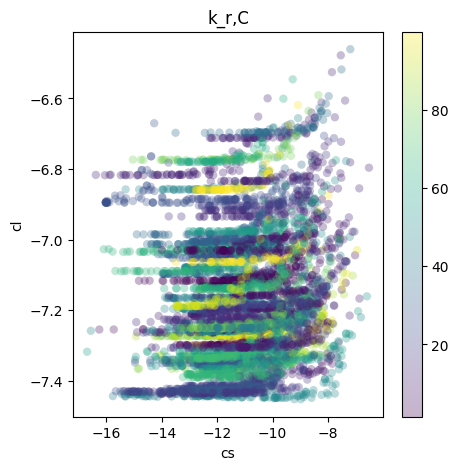

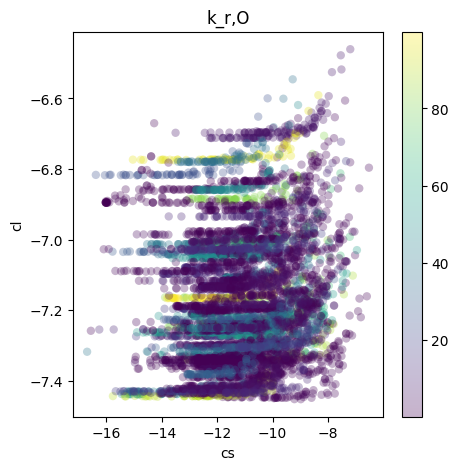

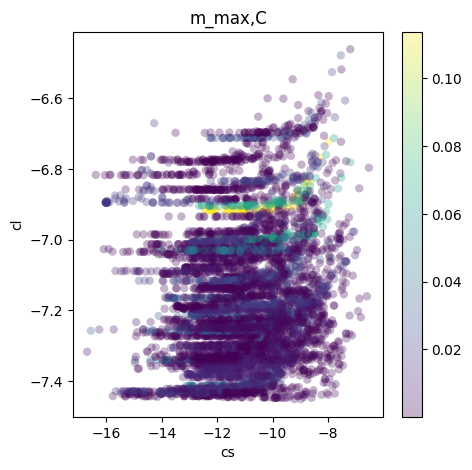

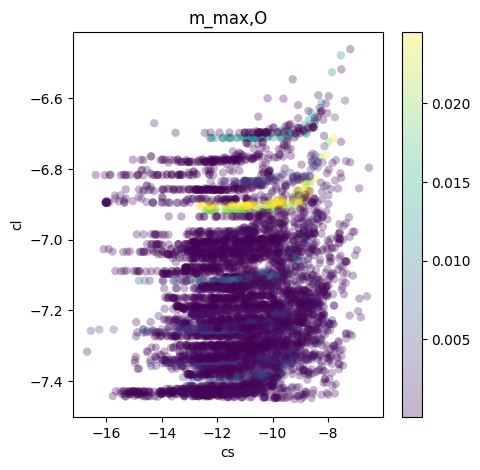

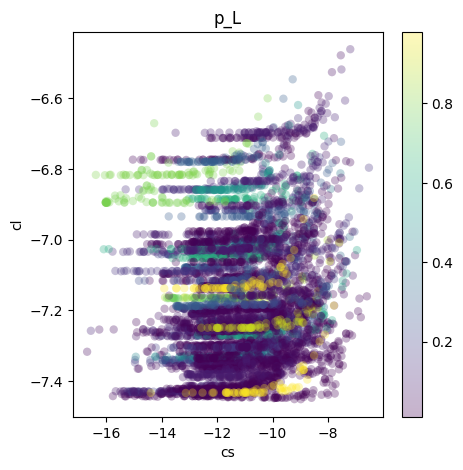

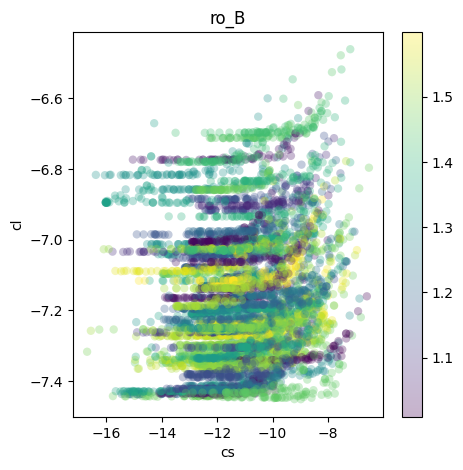

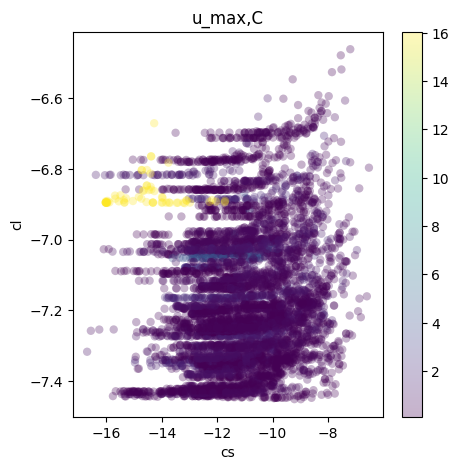

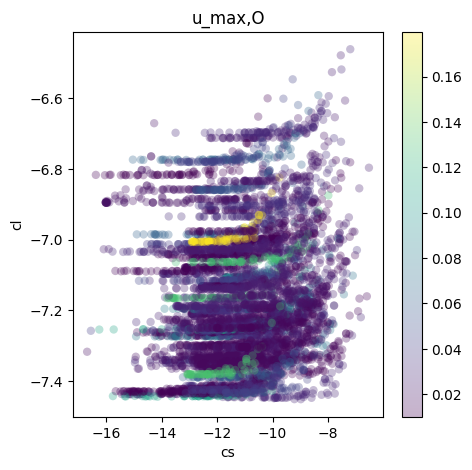

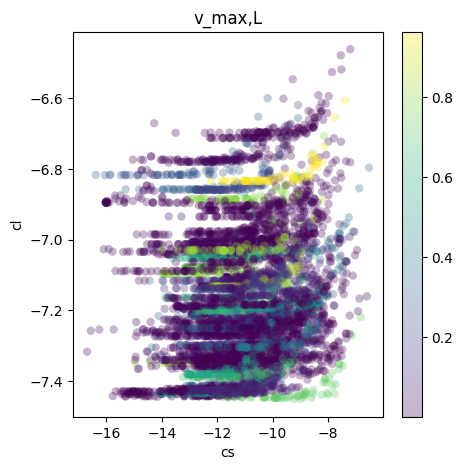

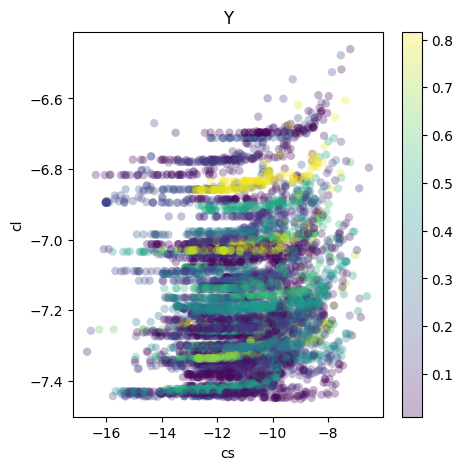

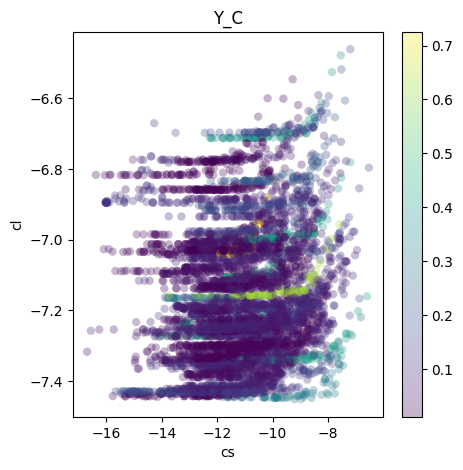

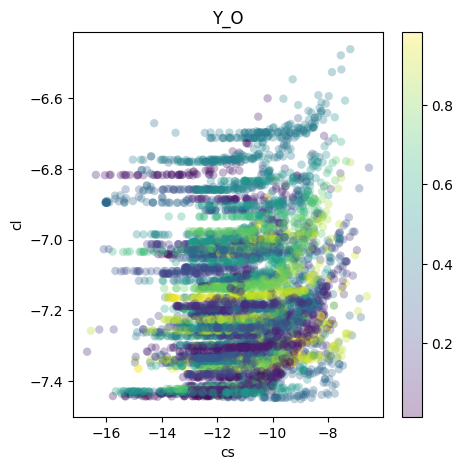

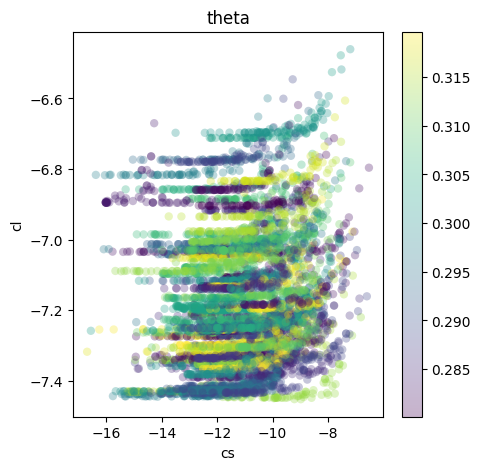

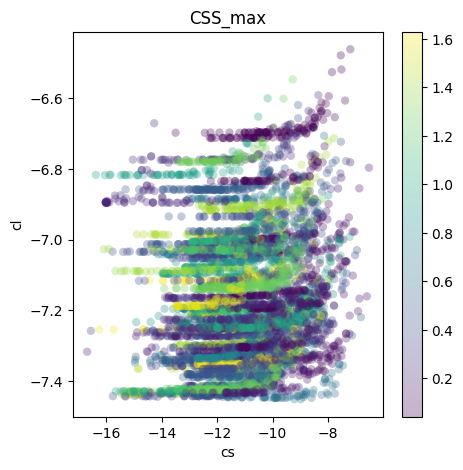

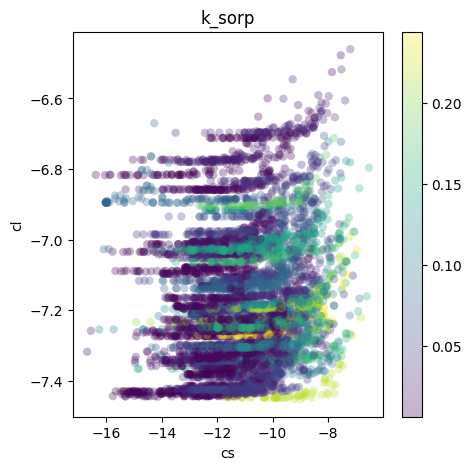

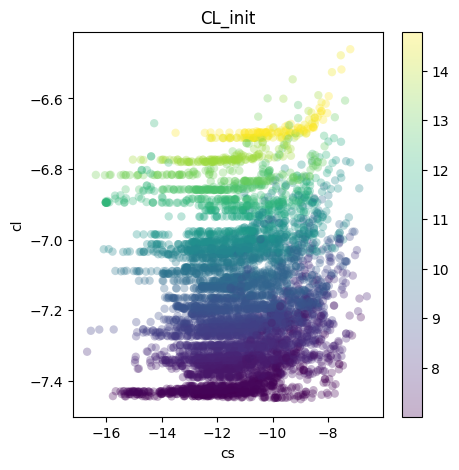

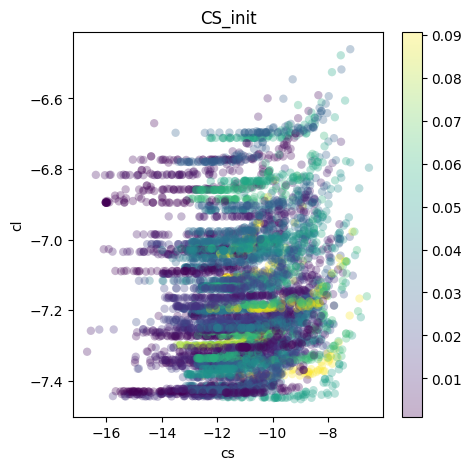

In [67]:
for nn in paramsets.columns.tolist():
    plt.scatter(np.log(df['cs']),np.log(df['cl']), 
                c=df[nn],
                alpha=0.3, edgecolors ='none')
    plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
    plt.title(nn)
    plt.colorbar()
    plt.xlabel('cs')
    plt.ylabel('cl')
    plt.show()